In [1]:
import os
import h5py    
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import cv2
import nrrd

In [2]:
def normalize_image(img, scale):
    """This is a simple opencv image normalization for 16 bit images.

    :param img: the numpy array of the 16bit image
    :return img: the normalized image
    """
    #cv2.normalize(img, img, 0, max, cv2.NORM_MINMAX)
    #norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    cv2.normalize(img, img, 0, scale, cv2.NORM_MINMAX)
    return img

def scaled(img, scale=20000):
    """First we find really high values, which are the bright spots and turn them down
    """
    dtype = img.dtype    
    epsilon = 0.99    
    _max = np.quantile(img[img>0], epsilon)
    scaled = (img * (scale / _max)).astype(dtype) # scale the image from original values to e.g., 30000/10000
    del img
    return scaled

def equalized(fixed, cliplimit=2):
    """Takes an image that has already been scaled and uses opencv adaptive histogram
    equalization. This cases uses 5 as the clip limit and splits the image into rows
    and columns. A higher cliplimit will make the image brighter. A cliplimit of 1 will
    do nothing. 

    :param fixed: image we are working on
    :return: a better looking image
    """
    
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(8, 8))
    fixed = clahe.apply(fixed)
    return fixed

def myhist(img, scale):
    hist, bins = np.histogram(img.flatten(), 65536, [0, 65536])  # Collect 16 bits histogram (65536 = 2^16).

    cdf = hist.cumsum()

    cdf_m = np.ma.masked_equal(cdf, 0)  # Find the minimum histogram value (excluding 0)
    cdf_m = (cdf_m - cdf_m.min())*scale/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint16')

    # Now we have the look-up table...
    return cdf[img]

def myhistXXX(i):
    _max = 2**16 - 1
    hist, bins = np.histogram(i, _max, (0, _max))
    # discard colors at each end of the histogram which are used by only 0.05% 
    tmp = np.where(hist > hist.sum() * 0.0005)[0]
    i_min = tmp.min()
    i_max = tmp.max()
    # stretch hist
    tmp = (i.astype(np.int32) - i_min) / (i_max - i_min) * (_max-1)
    img = np.clip(tmp, 0, (_max-1))
    return img.astype(np.uint16)


In [ ]:
animal = 'DK101'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/tif'
filepath = os.path.join(DIR, 'DK101_slide033_2023_02_15_axion2_S1_C1.tif')

In [ ]:
#For bigarr, look at 15812x43685, 16816x44463
startrow = 43685
endrow = 44463
startcol = 15812
endcol = 16816

In [ ]:
bigarr = io.imread(filepath)
print(f'dtype={bigarr.dtype} shape={bigarr.shape}')

In [ ]:
%%time
#scale = 2**16 - 1
scale = 20000
bigarr_scaled = scaled(bigarr, scale)
print(f'dtype={bigarr_scaled.dtype} shape={bigarr_scaled.shape}')
cropped = bigarr_scaled[startrow:endrow, startcol:endcol]
print(f'dtype={cropped.dtype} shape={cropped.shape}')
outpath = os.path.join(DIR, 'cropped_test.tif')
io.imsave(outpath, cropped)

In [30]:
filepath='/net/birdstore/Vessel/WBIM/Acquisition/LifeCanvas/003_20240209/00005/Scan/00060_00089/00000/tile.h5'

In [31]:
f = h5py.File(filepath, 'r')

In [32]:
for key in f.keys():
    print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
    print(type(f[key])) # get the object type: usually group or dataset

CH1
<class 'h5py._hl.group.Group'>
CH2
<class 'h5py._hl.group.Group'>
CH4
<class 'h5py._hl.group.Group'>


In [ ]:
#Get the HDF5 group; key needs to be a group name from above
group = f['CH1']
print(type(group))
#Checkout what keys are inside that group.
for key in group.keys():
    print(key)

In [ ]:
data = group['raw'][()]

In [ ]:
print(f'dtype={data.dtype} shape={data.shape}')

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]
plt.rcParams["figure.autolayout"] = True
plt.imshow(data[125,:,:], cmap='seismic')
#plt.show()

In [ ]:
scale = 2**16 - 1
cropped_scaled = scaled(cropped, scale)
outpath = os.path.join(DIR, f'cropped_scaled_{scale}.tif')
if not os.path.exists(outpath):
    io.imsave(outpath, cropped_scaled)

In [26]:
#filepath = '/home/eddyod/programming/ITKMontage/examples/SampleData_CMUrun2/tile_10.nrrd'
filepath = '/home/eddyod/programming/ITKMontage/examples/SampleData_DzZ_T1/tile_10.nrrd'
#filepath = '/home/eddyod/tmp/out.nrrd'
data, header = nrrd.read(filepath)
print(data.dtype, readdata.shape)

int16 (3, 364, 210)


In [22]:
arr = data[0,:,:]
arr.dtype, arr.shape, arr.ndim

(dtype('uint8'), (364, 210), 2)

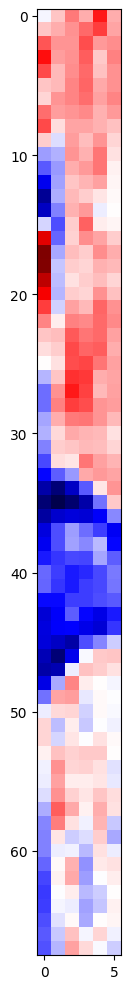

In [29]:
plt.rcParams["figure.figsize"] = [14, 10]
plt.rcParams["figure.autolayout"] = True
plt.imshow(data[0,:,:], cmap='seismic')